In [2]:
import torch
from torch import nn
from d2l import torch as d2l

In [3]:
# batch normalization function
# X: input tensor
# gamma: scale parameter
# beta: shift parameter
# moving_mean: running mean for inference
# moving_var: running variance for inference
# eps: small constant to avoid division by zero
# momentum: momentum for running mean/variance, used during training to update moving averages
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    if not torch.is_grad_enabled():
        # 推理模式：训练期间累积的滑动平均均值/方差
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        # 简单起见，我们假设输入为2D或4D张量（全连接层或卷积层的输入）
        assert len(X.shape) in (2, 4)
        # 全连接层，计算特征维度上的均值和方差
        if len(X.shape) == 2:
            # mean和var的形状与X的特征维度相同
            # dim=0表示按行计算均值和方差
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            # 卷积层，计算通道维度上的均值和方差
            # dim=(0,2,3)表示按批量和空间维度计算均值和方差
            # keepdim=True保持均值和方差的维度，以便后续广播运算
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        # 训练模式：使用当前批次的均值和方差进行归一化
        # X_hat: 用当前batch的均值和方差归一化到分布N(0,1)【标准正态分布】
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # 把当前batch算出的均值和方差，按照动量累积到moving_mean和moving_var中
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    # BN的仿射变换
    # 由于之前的归一化把数据变成了标准正态分布N(0,1)，所以需要通过gamma和beta进行仿射变换，恢复出数据的表达能力
    Y = gamma * X_hat + beta
    return Y, moving_mean, moving_var

In [4]:
# Batch Normalization Layer
class BatchNorm(nn.Module):
    # num_features: number of features (output dimension of fully connected layer or number of channels in convolutional layer)
    # num_dims: dimension of input data (2 for fully connected layer, 4 for convolutional layer)
    def __init__(self, num_features, num_dims):
        super().__init__()
        # num_features: 特征数量（全连接层的输出维度或卷积层的通道数）
        # num_dims: 输入数据的维度（2表示全连接层，4表示卷积层）
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # 可学习的缩放参数gamma和偏移参数beta
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # 用于推理的移动平均均值和方差，不作为模型参数参与梯度更新
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # 调用batch_norm函数进行批量归一化
        Y, self.moving_mean, self.moving_var = batch_norm(
            X,
            self.gamma,
            self.beta,
            self.moving_mean,
            self.moving_var,
            # 避免除零错误的小常数, 不同框架可能使用不同的默认值
            eps=1e-5,
            momentum=0.9,
        )
        return Y

In [10]:
# Example: Using BatchNorm in LeNet
# 通常在卷积层后和激活函数前使用批量归一化
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5),
    BatchNorm(6, num_dims=4),
    # nn.Sigmoid(),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5),
    BatchNorm(16, num_dims=4),
    # nn.Sigmoid(),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 4 * 4, 120),
    BatchNorm(120, num_dims=2),
    # nn.Sigmoid(),
    nn.ReLU(),
    nn.Linear(120, 84),
    # 最后输出层通常不使用批量归一化，但是可以根据需要添加
    # BatchNorm(84, num_dims=2),
    # nn.Sigmoid(),
    nn.ReLU(),
    nn.Linear(84, 10),
)

loss 0.115, train acc 0.956, test acc 0.891
66628.5 examples/sec on cuda:0


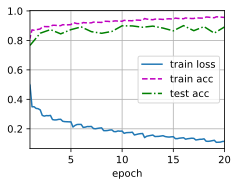

In [12]:
lr, num_epochs, batch_size = 0.5, 20, 192
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [9]:
print(net[1].gamma.reshape((-1,)))
print(net[1].beta.reshape((-1,)))

tensor([1.8949, 2.2514, 1.4749, 4.0024, 2.0519, 1.9638], device='cuda:0',
       grad_fn=<ViewBackward0>)
tensor([-1.2138,  0.3294, -1.3063,  2.9671,  0.2172,  0.5821], device='cuda:0',
       grad_fn=<ViewBackward0>)


In [ ]:
# 以下是简明实现
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5),
    nn.BatchNorm2d(6),
    nn.Sigmoid(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5),
    nn.BatchNorm2d(16),
    nn.Sigmoid(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 4 * 4, 120),
    nn.BatchNorm1d(120),
    nn.Sigmoid(),
    nn.Linear(120, 84),
    nn.BatchNorm1d(84),
    nn.Sigmoid(),
    nn.Linear(84, 10),
)